In [128]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import colorsys
import random
from sklearn.cluster import KMeans
from pathlib import Path
from enum import Enum
import os


matplotlib.rcParams["figure.dpi"] = 400
matplotlib.rcParams.update({'font.size': 5})

In [148]:
def nearColor(image, color, tolerance):
    offset = tolerance * 255;
    minColor = np.array([c - offset for c in color])
    maxColor = np.array([c + offset for c in color])
    return cv2.inRange(image, minColor, maxColor)

def smooth(arr, n):
    kernel = np.ones(n) / n
    return np.convolve(arr, kernel, mode='same')

def mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)
    return path

def cropOutRuler(image):
    mask_ruler1 = nearColor(image, (112, 113, 108), 0.05)
    mask_ruler2 = nearColor(image, (106, 94, 96), 0.05)
    mask = cv2.bitwise_or(mask_ruler1, mask_ruler2)

    width = mask.shape[1]
    height = mask.shape[0]
    x_distrib = smooth(np.array([ sum(mask[:, x]) for x in range(width) ]), 25)
    y_distrib = smooth(np.array([ sum(mask[y]) for y in range(height) ]), 25)
    
    X, Y = True, False
        
    if np.max(x_distrib) > np.max(y_distrib):
        trim_axis = X
        trim_axis_len = width
        distrib = x_distrib
    else:
        trim_axis = Y
        trim_axis_len = height
        distrib = y_distrib
        
    peak_cutoff = np.mean(distrib) + 1*np.std(distrib)
    peak = [np.max(distrib) if x>peak_cutoff else 0 for x in distrib]
    
    assert(len(peak) == trim_axis_len)
    
    lower_bound = np.min(np.nonzero(peak))
    upper_bound = np.max(np.nonzero(peak))
    
    if (upper_bound - 0) < (trim_axis_len - lower_bound):
        keep_range = (upper_bound, trim_axis_len)
    else:
        keep_range = (0, lower_bound)
        
        
    if trim_axis is X:
        image_trimmed = image[:, keep_range[0]:keep_range[1]]
        origin = (keep_range[0], 0)
    else:
        image_trimmed = image[keep_range[0]:keep_range[1], :]
        origin= (0, keep_range[0])
    
    return origin, image_trimmed


def getBGColor(image):
    km = KMeans(4, n_init='auto')
    clusters = km.fit(image.reshape(-1,3))
    colors = np.array(clusters.cluster_centers_, np.int32)
    reference_white = [250, 250, 250]
    bg_color = sorted(colors, key=lambda c: np.linalg.norm(c - reference_white))[0]
    return bg_color
    
        

def maskFragments(image, tolerance = 0.1):
    km = KMeans(4, n_init='auto')
    clusters = km.fit(image.reshape(-1,3))
    colors = np.array(clusters.cluster_centers_, np.int32)
    reference_brown = [172, 144, 119]
    reference_white = [250, 250, 250]

    papyrus_color = sorted(colors, key=lambda c: np.linalg.norm(c - reference_brown))[0]
    bg_color = sorted(colors, key=lambda c: np.linalg.norm(c - reference_white))[0]
    
    # Find likely papyrus pixels and dilate to make more cohesive
    papyrus_mask = nearColor(image, papyrus_color, tolerance)
    k10 = np.ones((10, 10), np.uint8)
    papyrus_mask = cv2.dilate(papyrus_mask, k10, iterations=3)
    
    # Fill in holes in the papyrus mask to account for local discoloration in the paper
    contours,_ = cv2.findContours(papyrus_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    papyus_mask = cv2.drawContours(papyrus_mask, contours, -1, [1], -1)
    
    # Remove any likely background pixels
    bg_mask = nearColor(image, bg_color, 0.15)
    papyrus_mask = cv2.bitwise_and(papyrus_mask, cv2.bitwise_not(bg_mask))
    
    # Find outlines of connected components
    contours,_ = cv2.findContours(papyrus_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contours = list(filter(lambda c: cv2.contourArea(c) > 150, contours))
    
    masked = cv2.bitwise_and(image, image, mask=papyrus_mask)
    
    return (masked, contours)

def alignBackMask(fm, bm, back):
        
    fm = cv2.cvtColor(cv2.threshold(fm.copy(), 1, 255, cv2.THRESH_BINARY)[1], cv2.COLOR_RGB2GRAY)
    bm = cv2.cvtColor(cv2.threshold(bm.copy(), 1, 255, cv2.THRESH_BINARY)[1], cv2.COLOR_RGB2GRAY)
    
    mode = cv2.MOTION_TRANSLATION
    warp = np.eye(2, 3, dtype=np.float32)
    max_iter = 100000;
    eps = 1e-3;
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, max_iter,  eps)
    
    _, warp = cv2.findTransformECC(fm, bm, warp, mode, criteria)    
    back_aligned = cv2.warpAffine(back.copy(), warp, (fm.shape[1],fm.shape[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
    
    return back_aligned

def getContourBB(contour):
    x,y,w,h = cv2.boundingRect(contour)
    return np.array([[x, y], [x+w, y+h]])

def unionBB(bb1, bb2):
    return np.array([[min(bb1[0][0], bb2[0][0]), min(bb1[0][1], bb2[0][1])],
            [max(bb1[1][0], bb2[1][0]), max(bb1[1][1], bb2[1][1])]])

def contourCenter(contour):
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return np.array([cx, cy])

# def contourDistance(c1, c2):
#     return np.linalg.norm(contourCenter(c1) - contourCenter(c2))

def contourDistance(c1, c2):
    c1 = cv2.approxPolyDP(c1,20,True)
    c2 = cv2.approxPolyDP(c2,20,True)
    minDist = 99999;
    for p1 in c1:
        for p2 in c2:
            dist = np.linalg.norm(p1 - p2)
            if (dist < minDist):
                minDist = dist
    return minDist

def contourMaxDistance(c1, c2):
    c1 = cv2.approxPolyDP(c1,20,True)
    c2 = cv2.approxPolyDP(c2,20,True)
    maxDist = 0;
    for p1 in c1:
        pointMinDist = 99999;
        for p2 in c2:
            dist = np.linalg.norm(p1 - p2)
            if (dist < pointMinDist):
                pointMinDist = dist
                
        if pointMinDist > maxDist:
            maxDist = pointMinDist
    
    maxDistInv = 0
    for p1 in c2:
        pointMinDist = 99999;
        for p2 in c1:
            dist = np.linalg.norm(p1 - p2)
            if (dist < pointMinDist):
                pointMinDist = dist
                
        if pointMinDist > maxDist:
            maxDistInv = pointMinDist

            
    return max(maxDist, maxDistInv)

def contourComplexity(contour):
    return cv2.contourArea(contour) / cv2.arcLength(contour,True)

def unionContourComplexity(c1, c2):
    return (cv2.contourArea(c1) + cv2.contourArea(c2)) / (cv2.arcLength(c1,True) + cv2.arcLength(c2,True))

def getClosestContour(contours, c1):
    minDist = 99999
    minCnt = None
    minI = None
    for i, c2 in enumerate(contours):
        if not np.array_equal(c1, c2):
            dist = contourDistance(c1, c2)
            if dist < minDist:
                minCnt = c2
                minDist = dist
                minI = i
    return minI, minCnt


CONTOUR_AREA_WEIGHT = 0.01

def matchContours(frontContours, backContours):
    matches = []
    totalDist = 0
    
    alreadyDoubleMatched = []
    
    for i, fc in enumerate(frontContours):
        
        if i in alreadyDoubleMatched:
            continue
        
        # Try on its own
        minSingleDist = 9999
        minSingleContour = None
        for j, bc in enumerate(backContours):
            dist = contourMaxDistance(fc, bc) + abs(cv2.contourArea(fc) - cv2.contourArea(bc))*CONTOUR_AREA_WEIGHT
#             if (i==10 and j==9):
#                 print(f"Front area: {cv2.contourArea(fc)}")
#                 print(f"Back area: {cv2.contourArea(bc)}")
#                 print(f"Total: {dist} CDist: {contourMaxDistance(np.concatenate(fc), bc)}, ADist: {abs(cv2.contourArea(fc) - cv2.contourArea(bc))}")            
            if dist < minSingleDist:
                minSingleDist = dist
                minSingleContour = bc
                
#         if (i==10):
#             f = fm.copy()
#             drawContours(f, [fc], 0.5)
#             drawContours(f, [minSingleContour], 0)
#             plt.imshow(f)
#             plt.title(f"Best single match: {minSingleDist}")
#             plt.show()

                
        # Try joined with its closest neighbor
        neighborIdx, neighbor = getClosestContour(frontContours, fc)
        
        minDoubleDist = 9999
        minDoubleContour = None
        if neighbor is not None:
            for j, bc in enumerate(backContours):
                dist = contourMaxDistance(np.concatenate([fc, neighbor]), bc) + \
                    abs(cv2.contourArea(fc) + cv2.contourArea(neighbor) - cv2.contourArea(bc))*CONTOUR_AREA_WEIGHT

    #             if (i==10 and j==9):
    #                 f = fm.copy()
    #                 drawContours(f, [fc, neighbor], 0.5)
    #                 drawContours(f, [bc], 1)
    #                 plt.imshow(f)
    #                 plt.title(f"{dist:.2f} vs {minSingleDist:.2f}")
    #                 print(f"Front area: {cv2.contourArea(fc)}")
    #                 print(f"Neighbor area: {cv2.contourArea(neighbor)}")
    #                 print(f"Back area: {cv2.contourArea(bc)}")
    #                 print(f"Total: {dist} CDist: {contourMaxDistance(np.concatenate(fc), bc)}, ADist: {abs(cv2.contourArea(fc) + cv2.contourArea(neighbor) - cv2.contourArea(bc))}")            
    #                 plt.show()

                if dist < minDoubleDist:
                    minDoubleDist = dist
                    minDoubleContour = bc

            if True or minSingleDist <= minDoubleDist:        
                matches.append([[fc], [minSingleContour]])
                totalDist += minSingleDist
            else:
                matches.append([[fc, neighbor], [minDoubleContour]])
                totalDist += minDoubleDist
                alreadyDoubleMatched.append(neighborIdx)
            
    return totalDist, matches

def cropContours(image, contourGroups, origin=(0,0)):
    origin=np.array(origin)
    output = []
    for cg in contourGroups:
        if len(cg)==1:
            bbox = getContourBB(cg[0])
        else:
            bbox = unionBB(getContourBB(cg[0]), getContourBB(cg[1]))
            
        mask = np.zeros((image.shape[0], image.shape[1]))
        cv2.drawContours(mask, cg, -1, 1, -1)
        clipped = image[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        mask = mask[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
        
        pos = origin + np.array([bbox[0][0], bbox[0][1]])
        output.append([pos, clipped, mask])
    
        
    return output

def drawContours(image, contours, hue=None):
    for i in range(len(contours)):
        if hue is None:
            hue = random.random()
        color = np.rint(np.array(colorsys.hsv_to_rgb(hue, 1, 1))*255)
        image = cv2.drawContours(image, contours, i, color, 2)
    return image

def drawBB(image, bb, hue=None, thickness=2):
    if hue is None:
            hue = random.random()
    color = np.rint(np.array(colorsys.hsv_to_rgb(hue, 1, 1))*255)
    image = cv2.rectangle(image, bb[0], bb[1], color, thickness)
    
def putText(image, text, pos, color, scale=1):
    cv2.putText(image, str(text), pos, cv2.FONT_HERSHEY_SIMPLEX, scale*2, (255,255,255), 15)
    cv2.putText(image, str(text), pos, cv2.FONT_HERSHEY_SIMPLEX, scale*2, (0,0,0), 8)
    cv2.putText(image, str(text), pos, cv2.FONT_HERSHEY_SIMPLEX, scale*2, color, 4)

def plotTriple(image, contours, masked):
    _, axs = plt.subplots(1, 3, figsize=(12,4))
    for a in axs:
        a.axis('off')
    axs[0].imshow(image)
    axs[1].imshow(drawContours(image, contours))  
    axs[2].imshow(masked)
    plt.show()

Reading image files from images/p.dura_39/01 ...
Find and cropping out ruler and reference colors...
Detecting papyrus fragment boundaries...
Found 49 fragments. Matching front/back fragments...
    Halfway there!
    Done.
Found set of 22 matches with an overall error of 3998.894.
Creating filled background image...
Plotting...


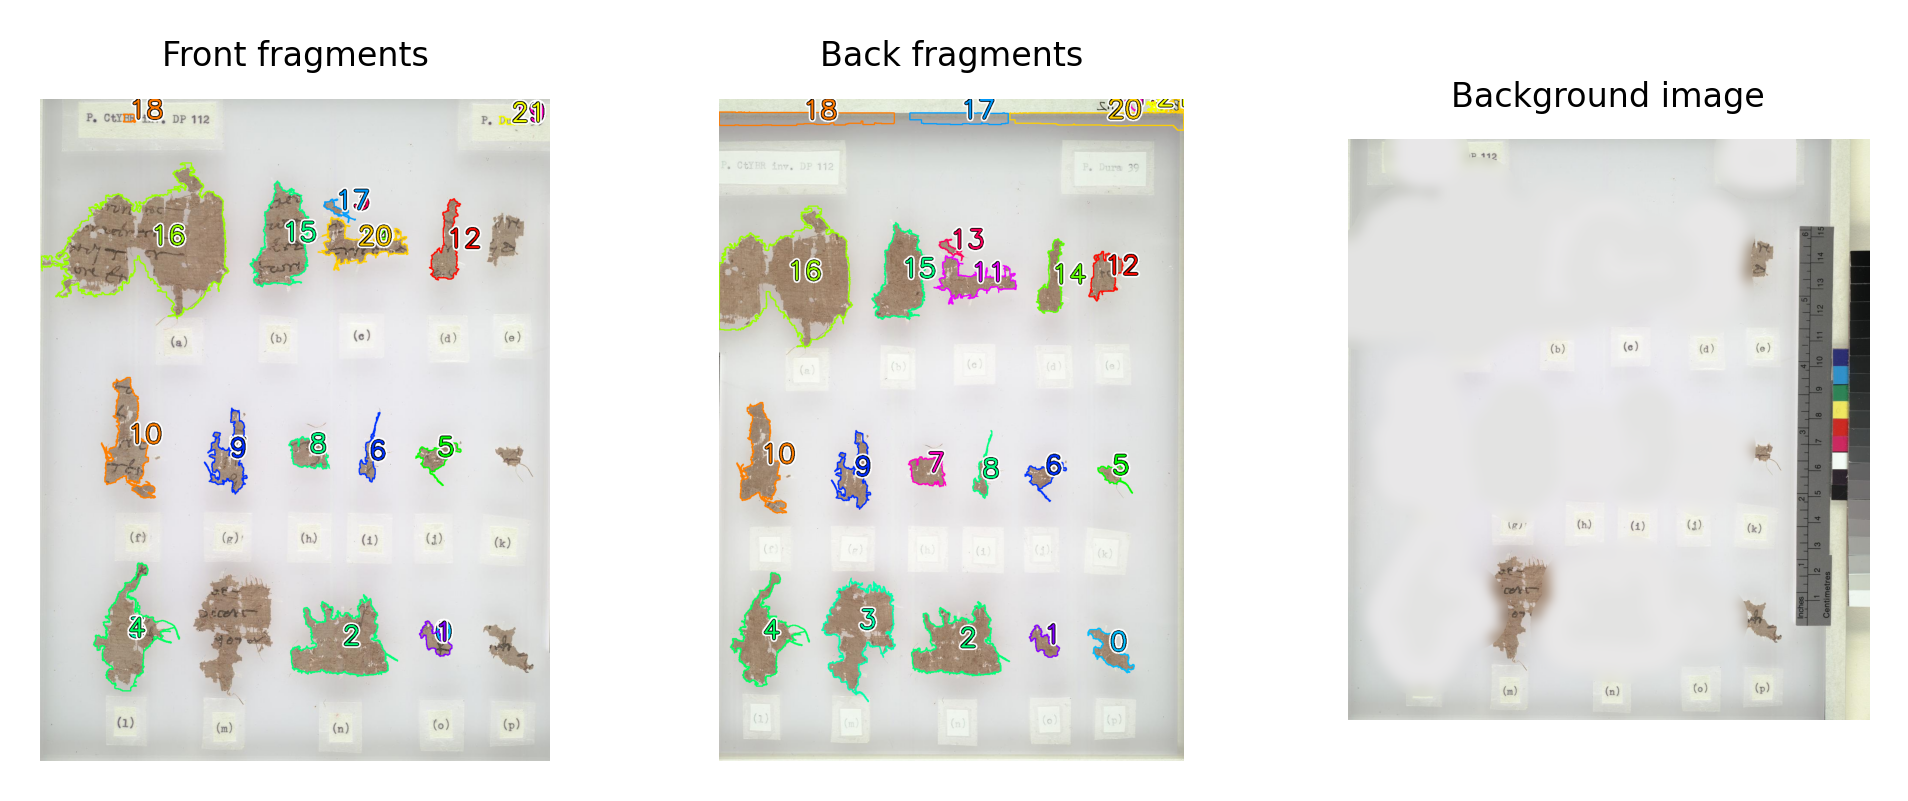

Write out to file? n
Reading image files from images/chla_9_390/01 ...
Find and cropping out ruler and reference colors...
Detecting papyrus fragment boundaries...
Found 15 fragments. Matching front/back fragments...
    Halfway there!
    Done.
Found set of 8 matches with an overall error of 1991.590.
Creating filled background image...
Plotting...


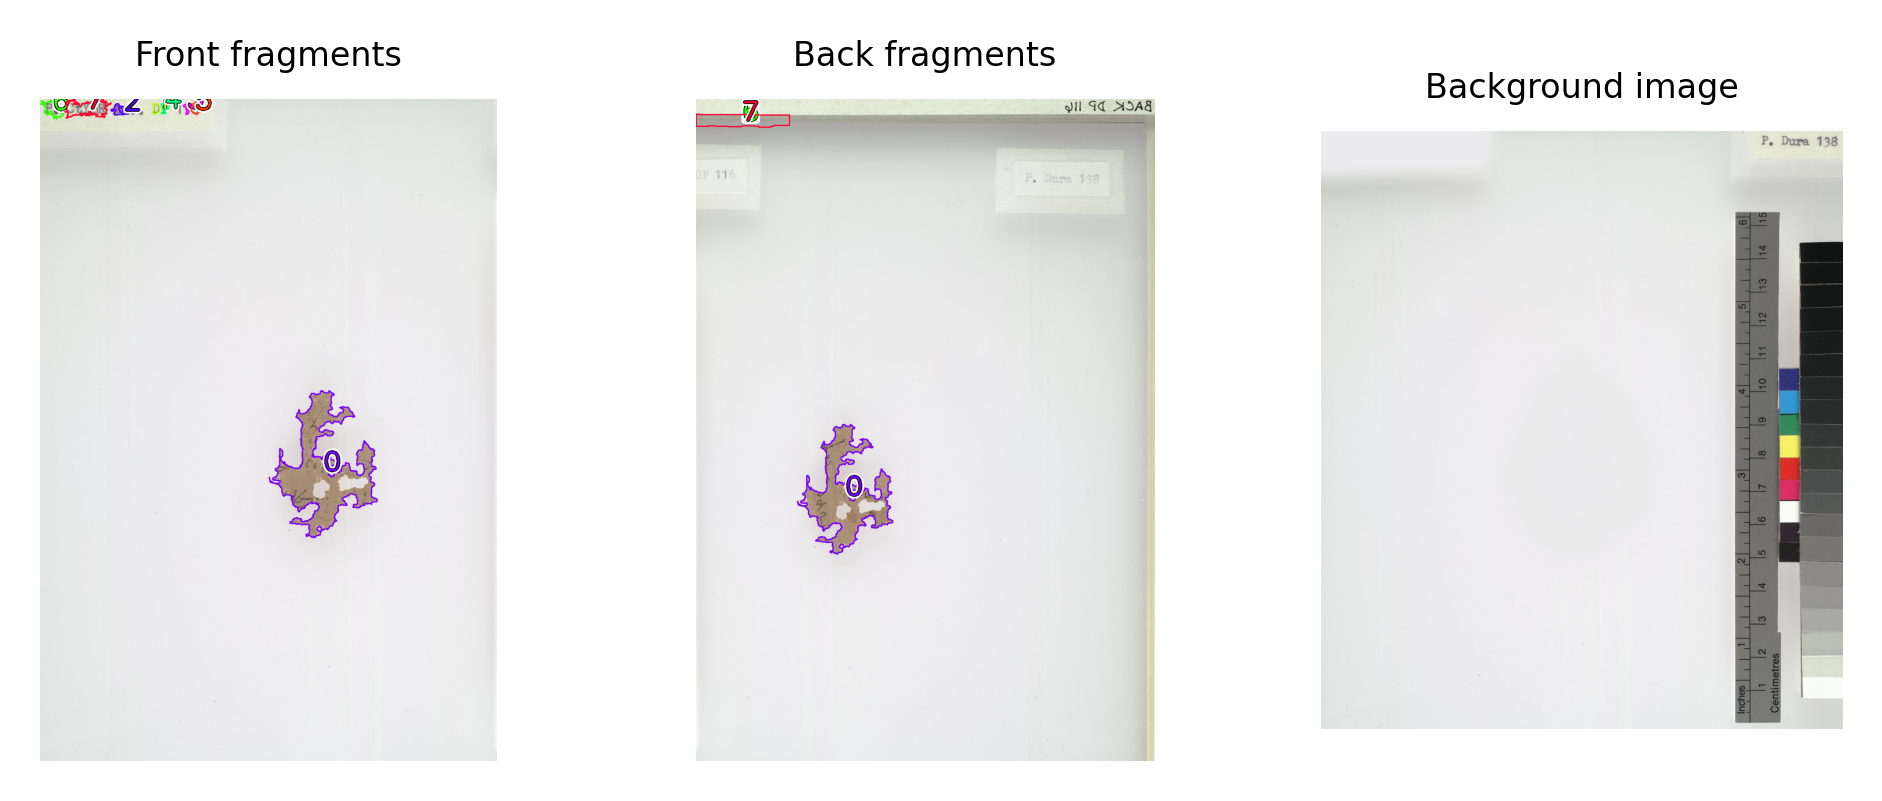

Write out to file? y
Writing images/chla_9_390/01/fragments/fragment000_front.png ...
Writing images/chla_9_390/01/fragments/fragment000_back.png ...
Writing images/chla_9_390/01/fragments/fragment001_front.png ...
Writing images/chla_9_390/01/fragments/fragment001_back.png ...
Writing images/chla_9_390/01/fragments/fragment002_front.png ...
Writing images/chla_9_390/01/fragments/fragment002_back.png ...
Writing images/chla_9_390/01/fragments/fragment003_front.png ...
Writing images/chla_9_390/01/fragments/fragment003_back.png ...
Writing images/chla_9_390/01/fragments/fragment004_front.png ...
Writing images/chla_9_390/01/fragments/fragment004_back.png ...
Writing images/chla_9_390/01/fragments/fragment005_front.png ...
Writing images/chla_9_390/01/fragments/fragment005_back.png ...
Writing images/chla_9_390/01/fragments/fragment006_front.png ...
Writing images/chla_9_390/01/fragments/fragment006_back.png ...
Writing images/chla_9_390/01/fragments/fragment007_front.png ...
Writing ima

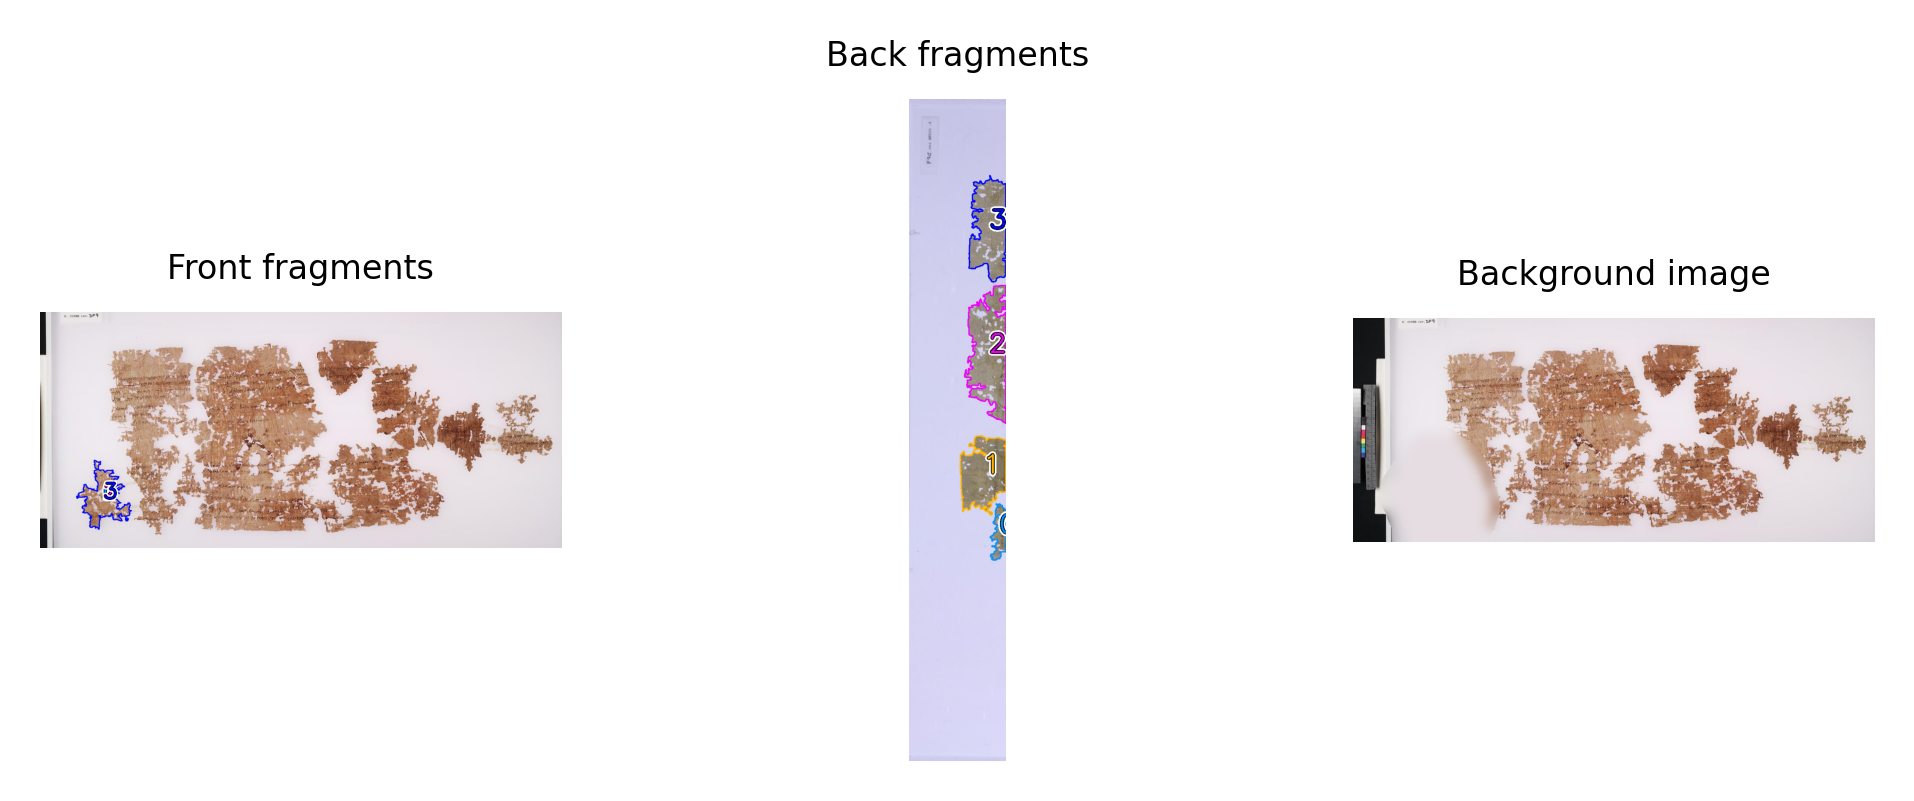

Write out to file? n
Reading image files from images/chla_7_331/01 ...
Find and cropping out ruler and reference colors...
Detecting papyrus fragment boundaries...
Found 18 fragments. Matching front/back fragments...
    Halfway there!
    Done.
Found set of 10 matches with an overall error of 1740.253.
Creating filled background image...
Plotting...


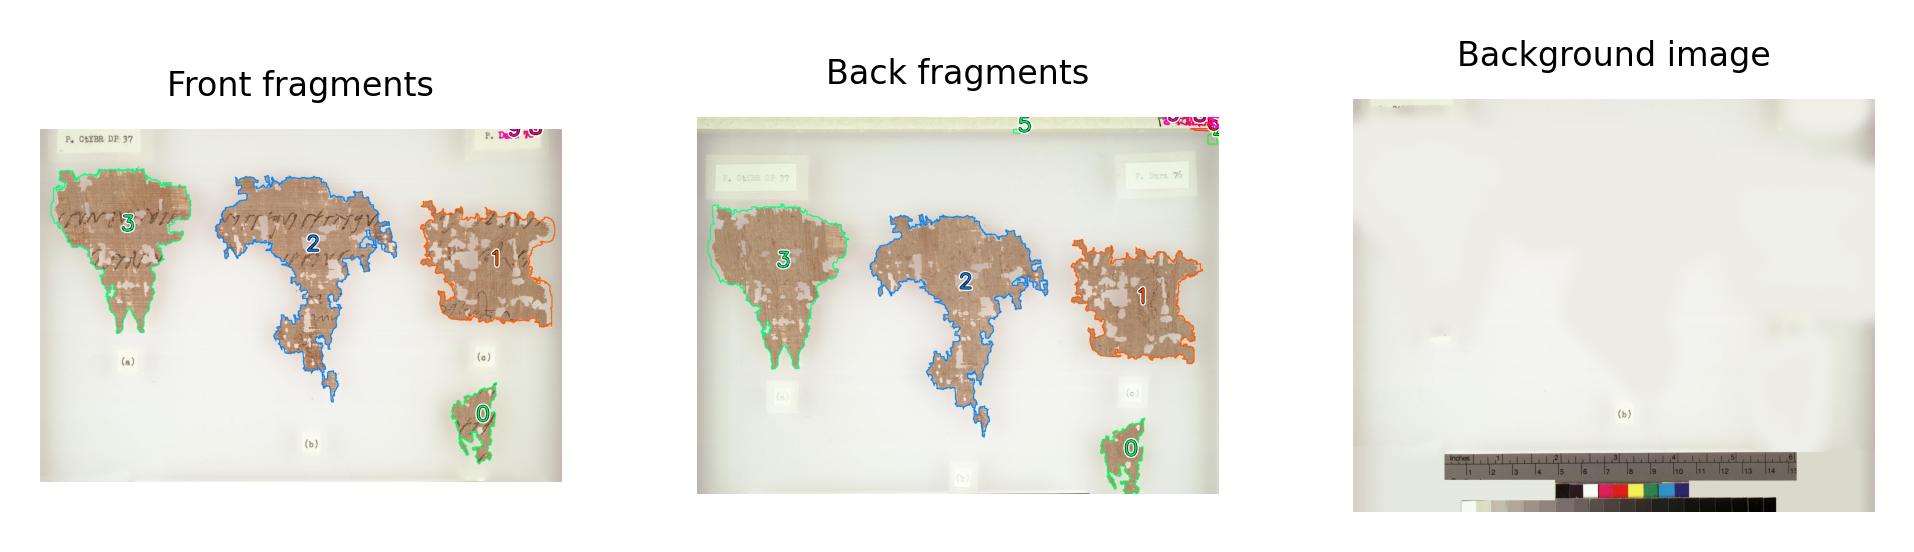

Write out to file? y
Writing images/chla_7_331/01/fragments/fragment000_front.png ...
Writing images/chla_7_331/01/fragments/fragment000_back.png ...
Writing images/chla_7_331/01/fragments/fragment001_front.png ...
Writing images/chla_7_331/01/fragments/fragment001_back.png ...
Writing images/chla_7_331/01/fragments/fragment002_front.png ...
Writing images/chla_7_331/01/fragments/fragment002_back.png ...
Writing images/chla_7_331/01/fragments/fragment003_front.png ...
Writing images/chla_7_331/01/fragments/fragment003_back.png ...
Writing images/chla_7_331/01/fragments/fragment004_front.png ...
Writing images/chla_7_331/01/fragments/fragment004_back.png ...
Writing images/chla_7_331/01/fragments/fragment005_front.png ...
Writing images/chla_7_331/01/fragments/fragment005_back.png ...
Writing images/chla_7_331/01/fragments/fragment006_front.png ...
Writing images/chla_7_331/01/fragments/fragment006_back.png ...
Writing images/chla_7_331/01/fragments/fragment007_front.png ...
Writing ima

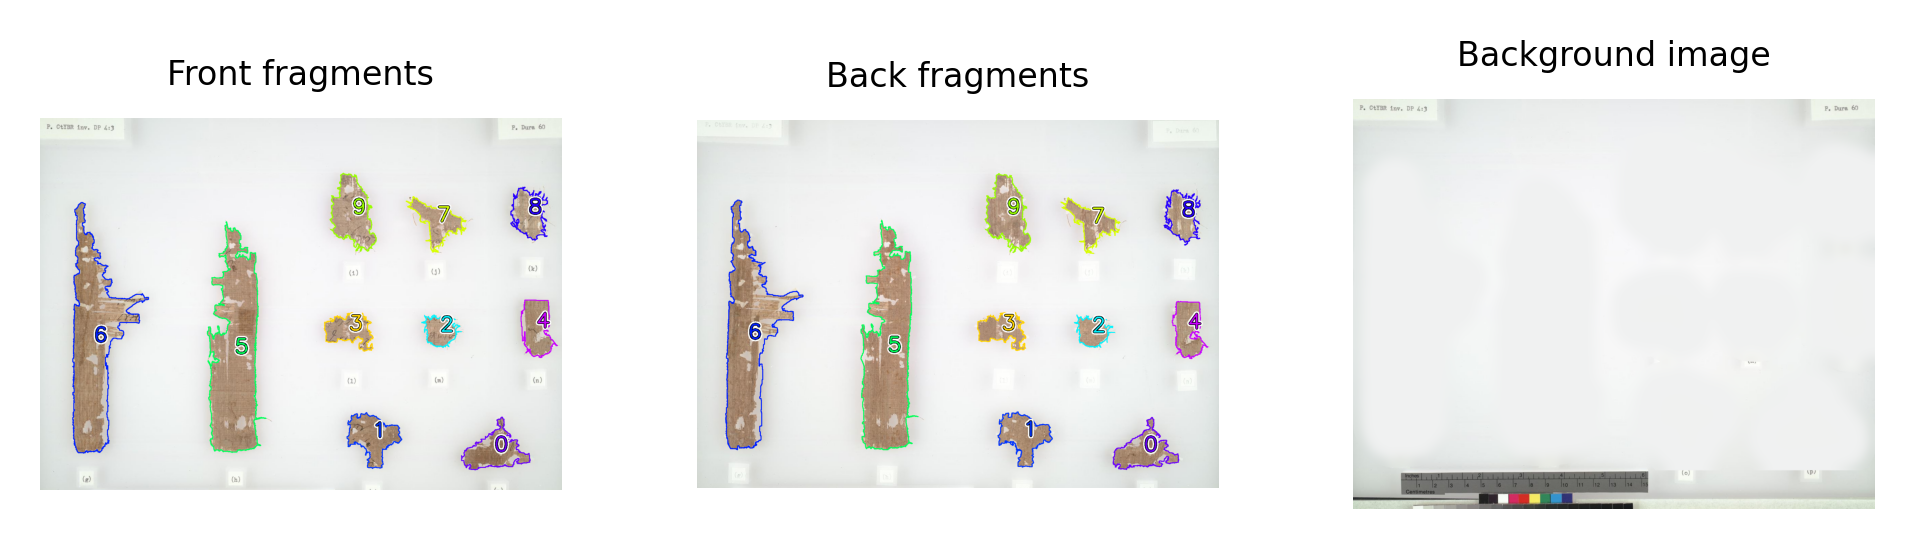

Write out to file? y
Writing images/chla_6_315/03/fragments/fragment000_front.png ...
Writing images/chla_6_315/03/fragments/fragment000_back.png ...
Writing images/chla_6_315/03/fragments/fragment001_front.png ...
Writing images/chla_6_315/03/fragments/fragment001_back.png ...
Writing images/chla_6_315/03/fragments/fragment002_front.png ...
Writing images/chla_6_315/03/fragments/fragment002_back.png ...
Writing images/chla_6_315/03/fragments/fragment003_front.png ...
Writing images/chla_6_315/03/fragments/fragment003_back.png ...
Writing images/chla_6_315/03/fragments/fragment004_front.png ...
Writing images/chla_6_315/03/fragments/fragment004_back.png ...
Writing images/chla_6_315/03/fragments/fragment005_front.png ...
Writing images/chla_6_315/03/fragments/fragment005_back.png ...
Writing images/chla_6_315/03/fragments/fragment006_front.png ...
Writing images/chla_6_315/03/fragments/fragment006_back.png ...
Writing images/chla_6_315/03/fragments/fragment007_front.png ...
Writing ima

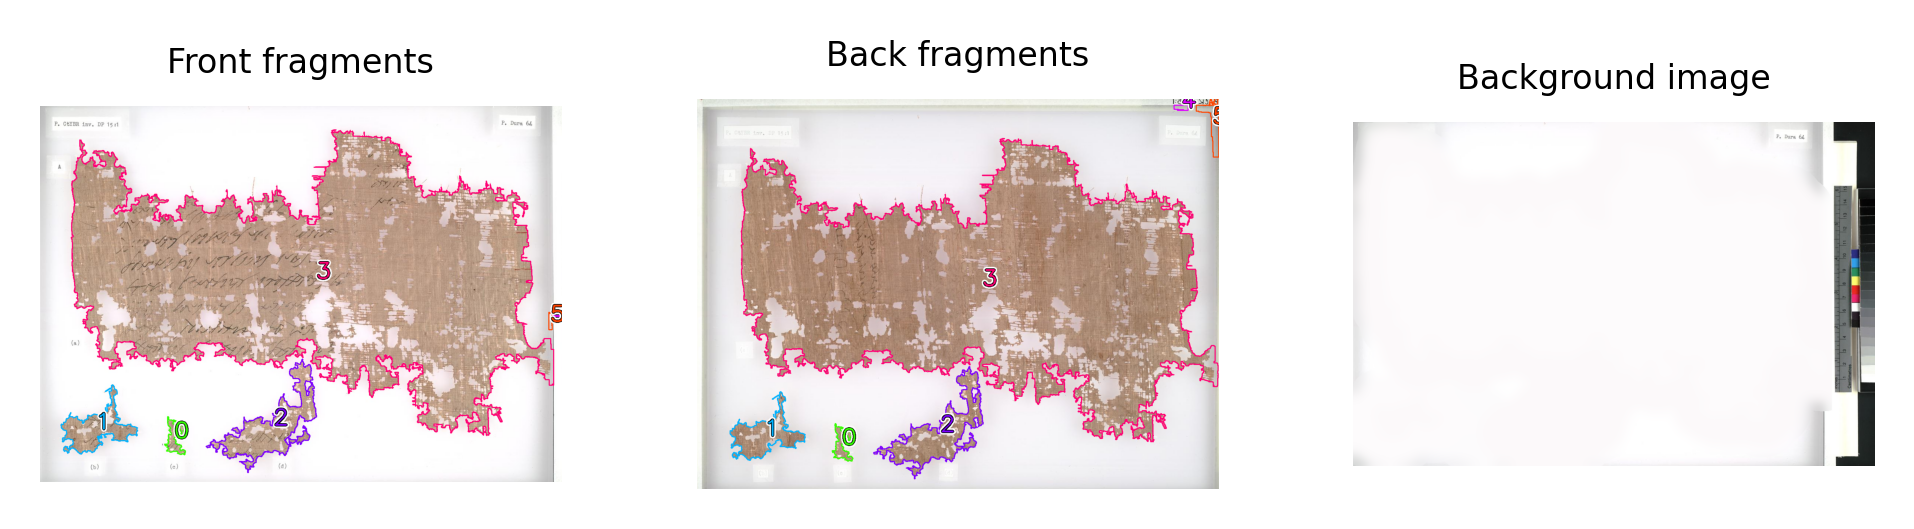

Write out to file? y
Writing images/rom.mil.rec_1_91/01/fragments/fragment000_front.png ...
Writing images/rom.mil.rec_1_91/01/fragments/fragment000_back.png ...
Writing images/rom.mil.rec_1_91/01/fragments/fragment001_front.png ...
Writing images/rom.mil.rec_1_91/01/fragments/fragment001_back.png ...
Writing images/rom.mil.rec_1_91/01/fragments/fragment002_front.png ...
Writing images/rom.mil.rec_1_91/01/fragments/fragment002_back.png ...
Writing images/rom.mil.rec_1_91/01/fragments/fragment003_front.png ...
Writing images/rom.mil.rec_1_91/01/fragments/fragment003_back.png ...
Writing images/rom.mil.rec_1_91/01/fragments/fragment004_front.png ...
Writing images/rom.mil.rec_1_91/01/fragments/fragment004_back.png ...
Writing images/rom.mil.rec_1_91/01/fragments/fragment005_front.png ...
Writing images/rom.mil.rec_1_91/01/fragments/fragment005_back.png ...
Writing images/rom.mil.rec_1_91/01/fragments/background.png ...
Writing images/rom.mil.rec_1_91/01/fragments/manifest.json
Reading im

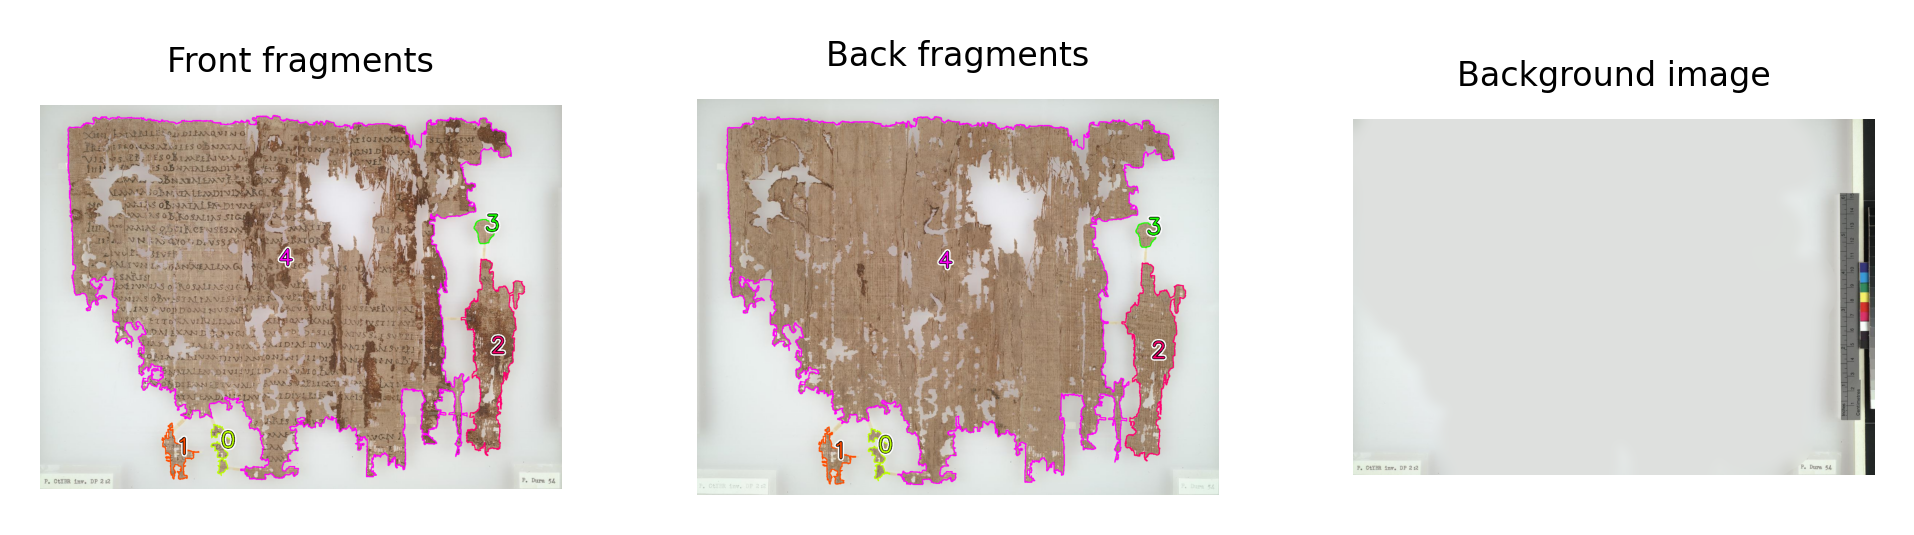

Write out to file? y
Writing images/rom.mil.rec_1_117/02/fragments/fragment000_front.png ...
Writing images/rom.mil.rec_1_117/02/fragments/fragment000_back.png ...
Writing images/rom.mil.rec_1_117/02/fragments/fragment001_front.png ...
Writing images/rom.mil.rec_1_117/02/fragments/fragment001_back.png ...
Writing images/rom.mil.rec_1_117/02/fragments/fragment002_front.png ...
Writing images/rom.mil.rec_1_117/02/fragments/fragment002_back.png ...
Writing images/rom.mil.rec_1_117/02/fragments/fragment003_front.png ...
Writing images/rom.mil.rec_1_117/02/fragments/fragment003_back.png ...
Writing images/rom.mil.rec_1_117/02/fragments/fragment004_front.png ...
Writing images/rom.mil.rec_1_117/02/fragments/fragment004_back.png ...
Writing images/rom.mil.rec_1_117/02/fragments/background.png ...
Writing images/rom.mil.rec_1_117/02/fragments/manifest.json
Reading image files from images/chla_7_347/01 ...
Find and cropping out ruler and reference colors...
Detecting papyrus fragment boundaries

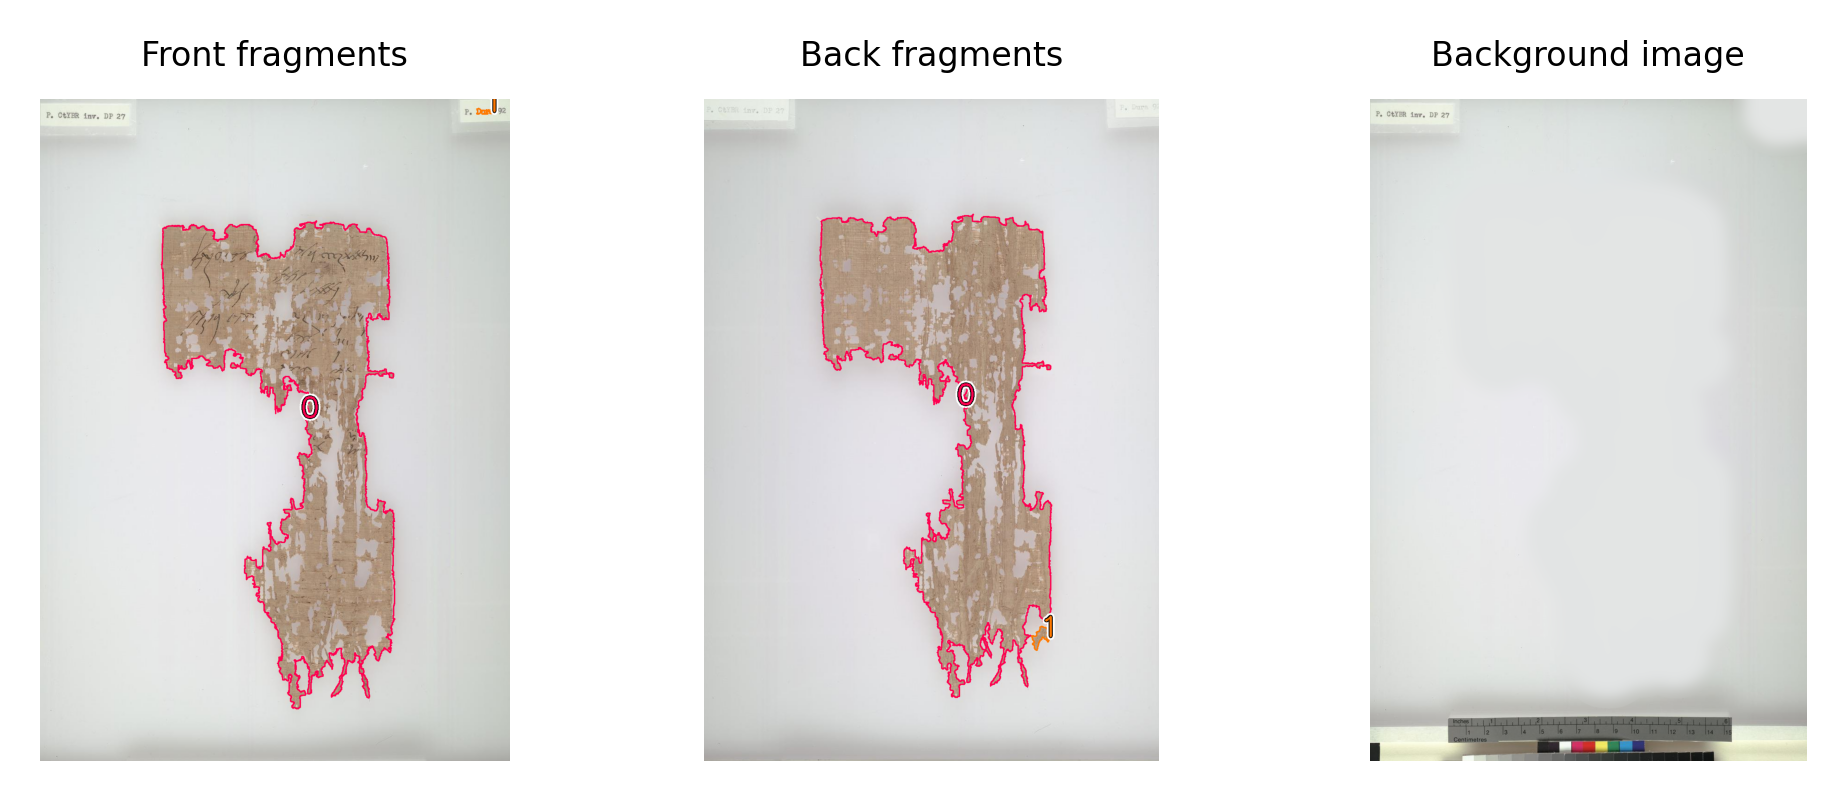

Write out to file? y
Writing images/chla_7_347/01/fragments/fragment000_front.png ...
Writing images/chla_7_347/01/fragments/fragment000_back.png ...
Writing images/chla_7_347/01/fragments/fragment001_front.png ...
Writing images/chla_7_347/01/fragments/fragment001_back.png ...
Writing images/chla_7_347/01/fragments/background.png ...
Writing images/chla_7_347/01/fragments/manifest.json
Reading image files from images/chla_6_319/02 ...
Find and cropping out ruler and reference colors...
Detecting papyrus fragment boundaries...
Found 7 fragments. Matching front/back fragments...
    Halfway there!
    Done.
Found set of 2 matches with an overall error of 518.844.
Creating filled background image...
Plotting...


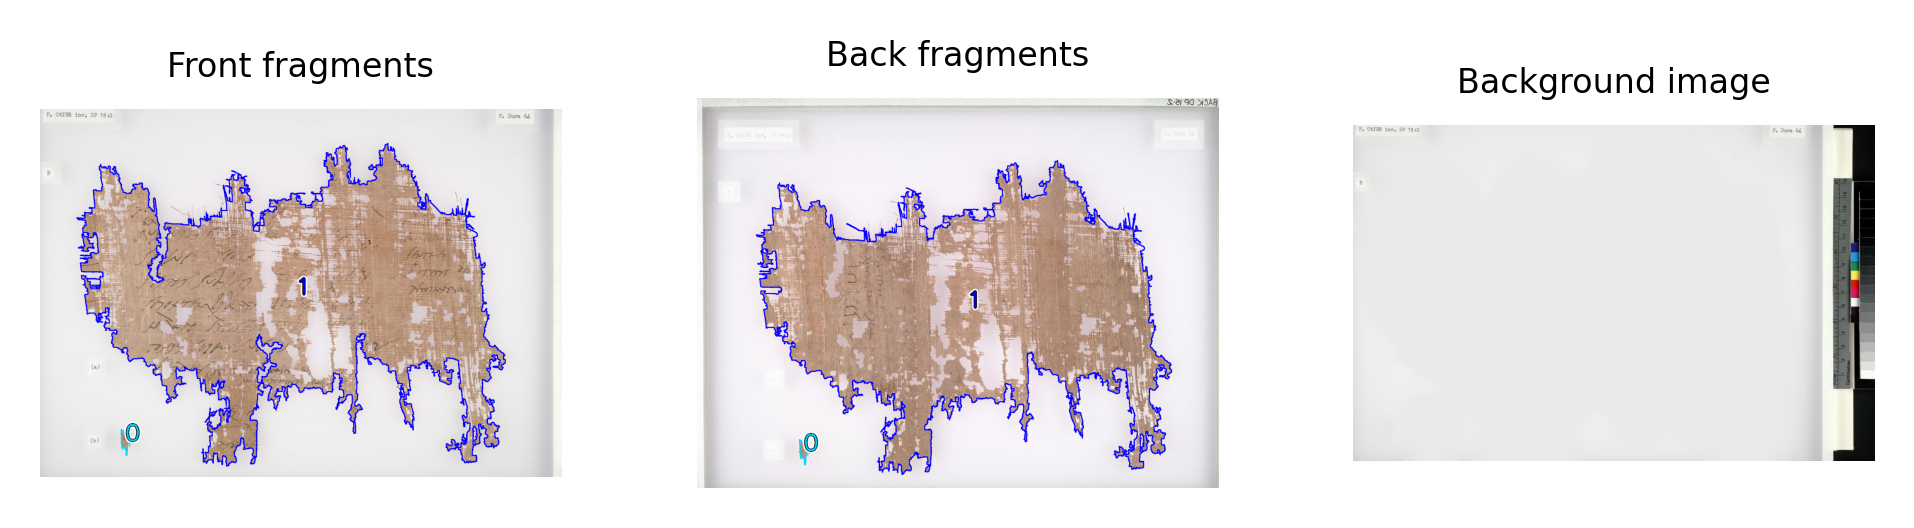

In [ ]:
all_filenames = [str(p) for p in Path("./images/").rglob("*.jpg")]

pairs = []
already_matched = []

def fnComplement(fn):
    if "front.jpg" in fn:
        return fn.replace("front.jpg", "back.jpg")
    elif "back.jpg" in fn:
        return fn.replace("back.jpg", "front.jpg")
    else:
        print(f"Error: filename {fn} has no complement")
        assert(False)
    
for fn in all_filenames:
    fnc = fnComplement(fn)
    if fnc in all_filenames and fn not in already_matched:
        pairs.append(sorted([fn, fnc], reverse=True))
        already_matched.append(fnc)
    else:
        pairs.append([fn])
        

complete_pairs = list(filter(lambda p: len(p)==2, pairs))
# print(complete_pairs)

# complete_pairs = [["images/rom.mil.rec_1_128/01/front.jpg", "images/rom.mil.rec_1_128/01/back.jpg"]]
# complete_pairs = [["images/chla_9_384/01/front.jpg", "images/chla_9_384/01/back.jpg"]]


for front_fn, back_fn in random.sample(complete_pairs, 10):
    dirname = front_fn.replace("/front.jpg", "")
    print("Reading image files from", dirname, "...")

    front = cv2.cvtColor(cv2.imread(front_fn), cv2.COLOR_BGR2RGB)
    back = cv2.cvtColor(cv2.imread(back_fn), cv2.COLOR_BGR2RGB)
    
    background_full = front.copy()
    
    print("Find and cropping out ruler and reference colors...")
    
    front_origin, front = cropOutRuler(front)
    _, back = cropOutRuler(back)
    
    back = cv2.flip(back, 1)
    
    print("Detecting papyrus fragment boundaries...")
    
    fm, fc = maskFragments(front)
    bm, bc = maskFragments(back)
    
    print(f"Found {len(fc)+len(bc)} fragments. Matching front/back fragments...")

    dist_for, matches_for = matchContours(fc, bc)
    print("    Halfway there!")
    dist_inv, matches_inv = matchContours(bc, fc)
    print("    Done.")
    
    if (dist_inv < dist_for):
        best_matches = matches_inv
        best_dist = dist_inv
        inverted = True
    else:
        best_matches = matches_for
        best_dist = dist_for
        inverted = False
        
    print(f"Found set of {len(best_matches)} matches with an overall error of {best_dist:.3f}.")
            
    print(f"Creating filled background image...")
        
    background = front.copy()
    blur_mask = np.zeros(background.shape)
    
    for i, (f, b) in enumerate(best_matches):
        if inverted:
            f, b = b, f
        cv2.drawContours(background, f, 0, getBGColor(front).tolist() , 150)    
        cv2.drawContours(blur_mask, f, 0, (255,255,255) , 200)
        cv2.drawContours(background, f, 0, getBGColor(front).tolist() , -1)
        
            
    background_blurred = cv2.GaussianBlur(background.copy(), (101,101), 0)
    background = np.where(blur_mask==(255,255,255), background_blurred, background)
    
    background_full[front_origin[1]:front_origin[1] + background.shape[0], \
                   front_origin[0]:front_origin[0]+background.shape[1]] = background
    
    print("Plotting...")
    
    fm1 = front.copy()
    bm1 = back.copy()
    for i, (f, b) in enumerate(best_matches):
        if inverted:
            f, b = b, f
        hue = random.random()
        color = [int(c * 255) for c in colorsys.hsv_to_rgb(hue, 1, 1)]
        drawContours(fm1, f, hue)
        drawContours(bm1, b, hue)
        for ff in f:
            putText(fm1, i, contourCenter(ff), color)
        for bb in b:
            putText(bm1, i, contourCenter(bb), color)
            

    fig, axs = plt.subplots(1, 3, figsize=(5,2))
    fig.tight_layout()
    axs = axs.flatten()
    for a in axs:
        a.axis('off')

    axs[0].imshow(fm1)
    axs[0].set_title("Front fragments")
    axs[1].imshow(bm1)
    axs[1].set_title("Back fragments")
    axs[2].imshow(background_full)
    axs[2].set_title("Background image")    
    
    plt.show()
    
    should_write = input("Write out to file? ")
    if (should_write!="y"):
        continue
    
    fmcs = [m[0] for m in best_matches]
    bmcs = [m[1] for m in best_matches]
    if inverted:
        fmcs, bmcs = bmcs, fmcs
    
    front_clipped = cropContours(front, fmcs, origin=front_origin)
    back_clipped = cropContours(back, bmcs)
    
    for i, (f,b) in enumerate(zip(front_clipped, back_clipped)):
        mkdir(dirname + "/fragments")
        f[1] = cv2.cvtColor(f[1], cv2.COLOR_RGB2BGR)
        front_transparent = np.dstack([f[1], f[2]*255])
        front_name = dirname + f"/fragments/fragment{i:03}_front.png"
        print(f"Writing {front_name} ...")
        cv2.imwrite(front_name, front_transparent)
        
        b[1] = cv2.cvtColor(b[1], cv2.COLOR_RGB2BGR)
        back_transparent = np.dstack([b[1], b[2]*255])
        back_name = dirname + f"/fragments/fragment{i:03}_back.png"
        print(f"Writing {back_name} ...")
        cv2.imwrite(back_name, back_transparent)
        
    bg_name = dirname + f"/fragments/background.png"
    print(f"Writing {bg_name} ...")
    cv2.imwrite(bg_name, background_full)
    
    print(f"Writing {dirname}/fragments/manifest.json")
    with open(f"{dirname}/fragments/manifest.json", "w+") as manifest:
        manifest.write("{\n")
        for i, (f,b) in enumerate(zip(front_clipped, back_clipped)):
            manifest.write(f'"fragment{i:03}" : "{f[0][0]},{f[0][1]}",\n')
        manifest.write("}")
    
    

fn='images/p.dura_32/01/front.jpg'


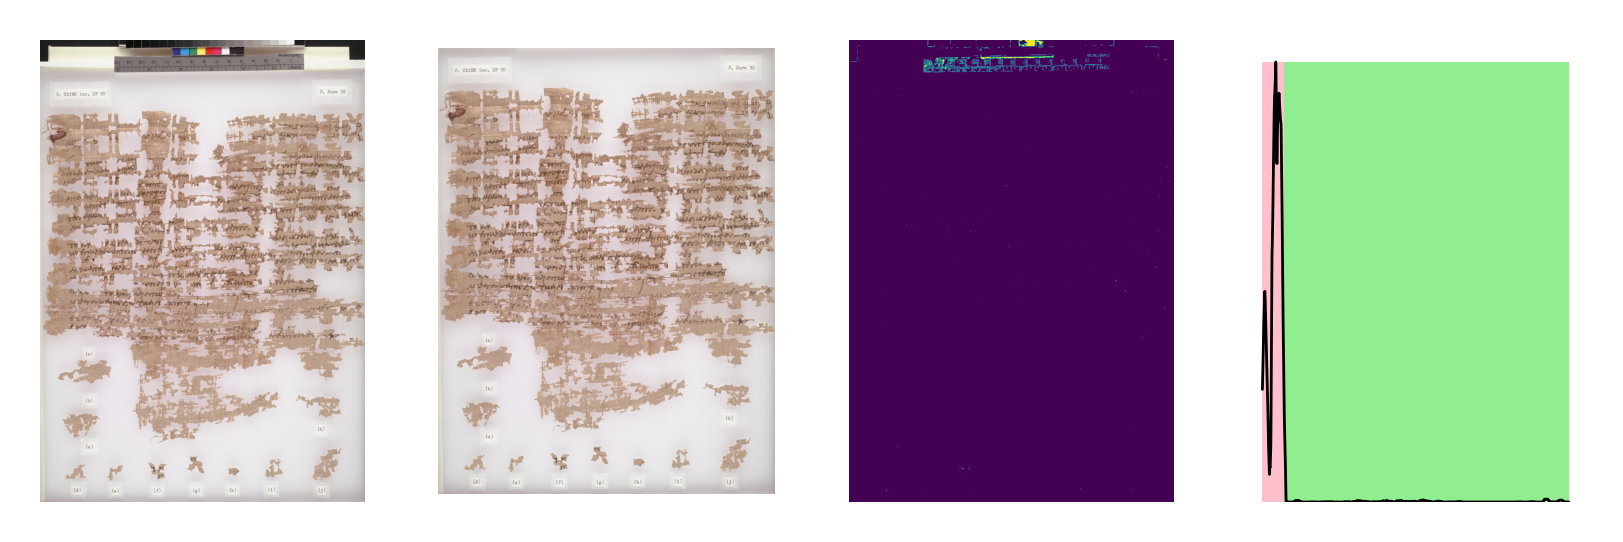

In [157]:
# fn = random.choice(all_filenames)

for fn in random.sample(all_filenames, 1):
    fn='images/p.dura_32/01/front.jpg'
    print(f"{fn=}")

    image = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
    mask_ruler1 = nearColor(image, (112, 113, 108), 0.05)
    mask_ruler2 = nearColor(image, (106, 94, 96), 0.05)
    mask = cv2.bitwise_or(mask_ruler1, mask_ruler2)

    width = mask.shape[1]
    height = mask.shape[0]
    x_distrib = smooth(np.array([ sum(mask[:, x]) for x in range(width) ]), 25)
    y_distrib = smooth(np.array([ sum(mask[y]) for y in range(height) ]), 25)
    
    X, Y = True, False
        
    if np.max(x_distrib) > np.max(y_distrib):
        trim_axis = X
        trim_axis_len = width
        distrib = x_distrib
    else:
        trim_axis = Y
        trim_axis_len = height
        distrib = y_distrib
        
    peak_cutoff = np.mean(distrib) + 1*np.std(distrib)
    peak = [np.max(distrib) if x>peak_cutoff else 0 for x in distrib]
    
    assert(len(peak) == trim_axis_len)
    
    lower_bound = np.min(np.nonzero(peak))
    upper_bound = np.max(np.nonzero(peak))
    
    if (upper_bound - 0) < (trim_axis_len - lower_bound):
        keep_range = (upper_bound, trim_axis_len)
    else:
        keep_range = (0, lower_bound)
        
        
    if trim_axis is X:
        image_trimmed = image[:, keep_range[0]:keep_range[1]]
    else:
        image_trimmed = image[keep_range[0]:keep_range[1], :]
        
    

    fig, axs = plt.subplots(1, 4, figsize=(5,1.5))
    keep_plot = [np.max(distrib) if (i>keep_range[0] and i<keep_range[1]) else 0 for i in range(len(distrib))]
    cut_plot = [np.max(distrib) if (i<keep_range[0] or i>keep_range[1]) else 0 for i in range(len(distrib))]
    for a in axs:
        a.axis('off')
    axs[0].imshow(image)
    axs[1].imshow(image_trimmed)
    axs[2].imshow(mask)
    axs[3].plot(range(len(distrib)), distrib, linewidth=0.5, color="black")
    axs[3].bar(range(len(keep_plot)), keep_plot, width=1, color="lightgreen")
    axs[3].bar(range(len(cut_plot)), cut_plot, width=1, color="pink")


    plt.show()